In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sem
import scipy.linalg as la

In [2]:
N = 8
p = N - 1
E = 8
Al, Bl, Cl, Dl, zl, wl = sem.semhat(p)
Q = np.zeros((N*E, p*E), dtype=np.float64)
for j in range(E):
    for i in range(N):
        if i+j*p == p*E:
            continue
        Q[i+j*N,i+j*p] = 1.
Q[-1,0] = 1.
Qt = Q.transpose()
A = np.dot(Qt, np.dot(np.kron(np.identity(E), Al), Q))
B = np.dot(Qt, np.dot(np.kron(np.identity(E), Bl), Q)) / E
D = np.dot(Qt, np.dot(np.kron(np.identity(E), Dl), Q)) * E
A = np.dot(D.transpose(), np.dot(B, D))
C = np.dot(B, D) 
z = np.zeros(p * E, dtype=np.float64 )
for j in range(E):
    z[j*p:(j+1)*p] = zl[:-1] + 2*j
z = (z - (E-1))/E

In [3]:
def bdf1(dt, x):
    y = la.solve(B - dt * (C-visc*A), np.dot(B, x[:,0]))
    #f = np.dot(A, x) #+ np.dot(Cl, x)
    #y = x + dt * f
    return y

def bdf2(dt, x):
    rhs = np.dot(B, 4./3.*x[:,0]- 1./3.*x[:,2])
    scale = 2.*dt/3.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf3(dt, x):
    rhs = np.dot(B, 18./11.*x[:,0]- 9./11.*x[:,2] + 2./11.*x[:,4])
    scale = 6.*dt/11.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf4(dt, x):
    rhs = np.dot(B, 48./25.*x[:,0]- 36./25.*x[:,2] + 16./25.*x[:,4] - 3./25. * x[:,6])
    scale = 12.*dt/25.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf5(dt, x):
    rhs = np.dot(B, 300./137.*x[:,0]- 300./137.*x[:,2] + 200./137.*x[:,4] - 75./137. * x[:,6] + 12./137. * x[:,8])
    scale = 60.*dt/137.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf2opt(dt, x):
    beta = 0.48
    rhs_2 = 4./3.*x[:,0]- 1./3.*x[:,2]
    rhs_3 = 18./11.*x[:,0]- 9./11.*x[:,2] + 2./11.*x[:,4]
    rhs = np.dot(B, beta*rhs_3 + (1-beta)*rhs_2)
    scale = beta * 6.*dt/11. + (1-beta) * 2.*dt/3.
    y = la.solve(B - scale * (C-visc*A), rhs )
    return y

def bdf3ex3(dt, x):
    scale = 6.*dt/11.
    C_approx = 3 * x[:,1] - 3*x[:,3] + x[:,5]
    rhs = np.dot(B, 18./11.*x[:,0]- 9./11.*x[:,2] + 2./11.*x[:,4]) + scale * C_approx
    y = la.solve(B + scale*visc*A, rhs)
    return y

def bdf5ex3(dt, x):
    scale = 60.*dt/137.
    C_approx = 3 * x[:,1] - 3*x[:,3] + x[:,5]
    rhs = np.dot(B, 
                 300./137.*x[:,0]
                 - 300./137.*x[:,2] 
                 + 200./137.*x[:,4] 
                 - 75./137. * x[:,6] 
                 + 12./137. * x[:,8]) + scale * C_approx

    y = la.solve(B + scale*visc*A, rhs)
    return y

def bdf2ex2(dt, x):
    scale = 2.*dt/3.
    C_approx = 2 * x[:,1] - 1*x[:,3]
    rhs = np.dot(B, 4./3.*x[:,0]- 1./3.*x[:,2]) + scale * C_approx
    y = la.solve(B + scale*visc*A, rhs )
    return y

In [4]:
def simulate(IC, Cycles, dt, advance, sub = 1):
    NT = int(Cycles * 2 / dt)
    
    # Bootstrap
    dat = np.zeros((IC.size, 10), dtype=np.float64)
    boot = np.zeros((IC.size, 4), dtype=np.float64)
    
    boot[:,0] = IC.astype(np.float64)
    boot[:,1] = np.dot(C, IC)

    dat[:,0] = boot[:,0]
    dat[:,1] = boot[:,1]
    
    adv = bdf1(dt/sub, boot)
    boot = np.roll(boot, 2, 1)
    boot[:,0] = adv
    boot[:,1] = np.dot(C, adv)
    
    if sub == 1:
        dat = np.roll(dat, 2, 1)
        dat[:,0] = boot[:,0]
        dat[:,1] = boot[:,1]        

    adv = bdf2(dt/sub, boot)
    boot = np.roll(boot, 2, 1)
    boot[:,0] = adv
    boot[:,1] = np.dot(C, adv)

    for i in range(2, 4*sub):
        if i % sub == 0:
            dat = np.roll(dat, 2, 1)
            dat[:,0] = boot[:,0]
            dat[:,1] = boot[:,1]

        adv = bdf2(dt/sub, boot)
        boot = np.roll(boot, 2, 1)
        boot[:,0] = adv
        boot[:,1] = np.dot(C, adv)

    dat = np.roll(dat, 2, 1)
    dat[:,0] = boot[:,0]
    dat[:,1] = boot[:,1]
    
    for i in range(4, NT):
        adv = advance(dt, dat)
        dat = np.roll(dat, 2, 1)
        dat[:,0] = adv
        dat[:,1] = np.dot(C, adv)
        
    return adv



def calculate_error(IC, ref, Cycles, dt, advance, sub = 1):
    out = simulate(IC, Cycles, dt, advance, sub)
        
    #err = np.exp(-np.square(z)/(4*visc*(2*Num + delta/(4*visc)) )) - bar
    err = ref - out
    norm = np.sqrt(np.dot(err.transpose(), np.dot(B, err)))
    return norm

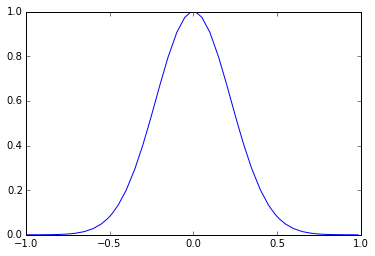

In [5]:
delta = .1
IC = np.exp(-np.square(z)/delta)
plt.plot(z, IC)

In [6]:
Cycles = 1
Re = 16384
visc = 2 / Re
ref = simulate(IC, Cycles, 2.**(-19), bdf2)

In [7]:
nsamp = 12

dx_min = np.min(z[1:] - z[:-1])

#dts = np.power(np.arange(1, nsamp+1, 1), -2.)
foo = np.power(2, np.arange(0, nsamp)).astype(int)
dts = 1./foo

errs_2  = np.zeros(nsamp)
errs_2o = np.zeros(nsamp)
errs_3  = np.zeros(nsamp)
errs_3e = np.zeros(nsamp)
errs_4 = np.zeros(nsamp)
errs_5 = np.zeros(nsamp)
errs_5e = np.zeros(nsamp)

num_sub = 19

for i in range(nsamp):
    subs = 2**(num_sub - i)
    print(dts[i], subs)
    errs_2[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf2)
    errs_2o[i] = calculate_error(IC, ref, Cycles, dts[i], bdf2opt, sub = subs)
    errs_3[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf3, sub = subs)
    if dts[i] < 0.4 * dx_min:
        print("Trying {}".format(dts[i]))
        errs_3e[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf3ex3, sub = subs)
        errs_5e[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf5ex3, sub = subs)
    if dts[i] < 1./16:
        errs_4[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf4, sub = subs)
        errs_5[i]  = calculate_error(IC, ref, Cycles, dts[i], bdf5, sub = subs)

1.0 524288
0.5 262144
0.25 131072
0.125 65536
0.0625 32768
0.03125 16384
0.015625 8192
0.0078125 4096
0.00390625 2048
Trying 0.00390625
0.001953125 1024
Trying 0.001953125
0.0009765625 512
Trying 0.0009765625
0.00048828125 256
Trying 0.00048828125


3.98135320111
4.90006105801
2.88936361137


/home/maxhutch/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/home/maxhutch/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log2
/home/maxhutch/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2
/home/maxhutch/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log2
/home/maxhutch/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log2
/home/maxhutch/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log2


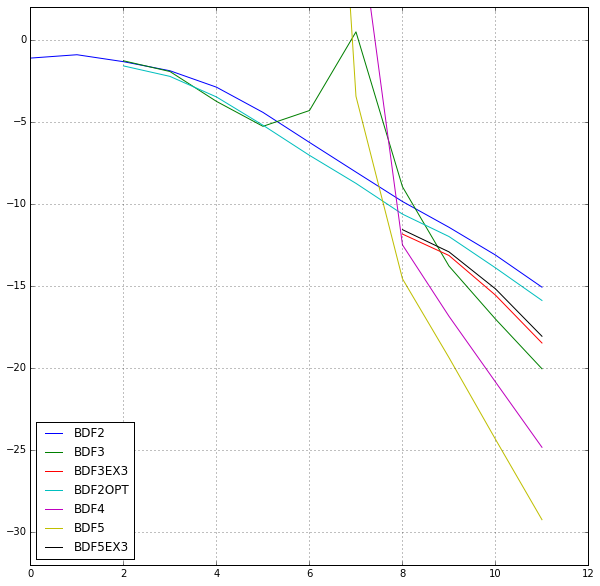

In [8]:
plt.figure(figsize=(10,10))
plt.plot(-np.log2(dts), np.log2(errs_2), label="BDF2")
plt.plot(-np.log2(dts), np.log2(errs_3), label="BDF3")
plt.plot(-np.log2(dts), np.log2(errs_3e), label="BDF3EX3")
plt.plot(-np.log2(dts), np.log2(errs_2o),label="BDF2OPT")
plt.plot(-np.log2(dts), np.log2(errs_4), label="BDF4")
plt.plot(-np.log2(dts), np.log2(errs_5), label="BDF5")
plt.plot(-np.log2(dts), np.log2(errs_5e), label="BDF5EX3")
plt.grid(True);
plt.ylim(ymax=2., ymin=-32);
plt.legend(loc=3);
print(np.log2(errs_4[-2]/errs_4[-1]))
print(np.log2(errs_5[-2]/errs_5[-1]))
print(np.log2(errs_5e[-2]/errs_5e[-1]))

In [9]:
# from https://commons.wikimedia.org/wiki/File:Stability_region_for_BDF1.svg
BFDcoeffs = { 1: {'alpha': [1, -1], 'beta': 1},
              2: { 'alpha': [3, -4, 1], 'beta': 2 },
              3: { 'alpha': [11, -18, 9, -2], 'beta': 6 },
              4: { 'alpha': [25, -48, 36, -16, 3], 'beta': 12 },
              5: { 'alpha': [137, -300, 300, -200, 75, -12], 'beta': 60 },
              6: { 'alpha': [147, -360, 450, -400, 225, -72], 'beta': 60 } }

# Returns > 1 if argument is not in region of absolute stability
def stabilityFunction(hTimesLambda, s):
    stabPolyCoeffs = list(BFDcoeffs[s]['alpha'])
    stabPolyCoeffs[0] -= hTimesLambda * BFDcoeffs[s]['beta']
    return max(abs(np.roots(stabPolyCoeffs)))

In [10]:
def plot_stability(Re, dt, s, c = 8, advance=bdf3ex3):
    visc = 2. / Re
    plt.plot(z, IC)
    #plt.plot(z, ref)
    plt.plot(z, simulate(IC, c, dt, advance))
    plt.grid(True)

    ev = la.eigvals(dt*C, B)
    #plt.figure(figsize=(10, 10))
    #plt.scatter(np.real(ev), np.imag(ev))
    
    ev = la.eigvals(dt*(C-visc*A), B)

    x = np.linspace(np.min(np.real(ev)),0, num=200)
    y = np.linspace(0,np.max(np.imag(ev)), num=200)
    [X,Y] = np.meshgrid(x,y)
    Z = np.zeros(X.shape)
    for m in range(X.shape[0]):
        for n in range(X.shape[1]):
            Z[m,n] = stabilityFunction(X[m,n] + 1j * Y[m,n], s)

    unstable_ev = []
    for m in range(ev.shape[0]):
        foo = stabilityFunction(ev[m], s)
        if foo > 1.0:
            unstable_ev.append(ev[m])
            print("({:f}, {:f}) unstable with z = 1 + {:e}".format(ev[m].real, ev[m].imag, foo-1.))
    unstable = np.array(unstable_ev)
    
    plt.figure(figsize=(10, 10))
    plt.contour(X, Y, Z, [1], colors='k')
    plt.contourf(X, Y, Z, [0,1], colors=[[1, 0.5, 0.8]])

    plt.scatter(np.real(ev), np.imag(ev))
    plt.scatter(np.real(unstable), np.imag(unstable), color='r')
    ev_A = la.eigvals(-dt*visc*A, B)
    plt.scatter(np.real(ev_A), np.imag(ev_A), color='g')
    ev_C = la.eigvals(dt*C, B)
    plt.scatter(np.real(ev_C), np.imag(ev_C), color='y')

    plt.grid(True)
    plt.ylim(ymin=np.min(np.imag(ev))*1.1, ymax=np.max(np.imag(ev))*1.1)

(-0.424717, 1.646799) unstable with z = 1 + 1.888649e-02
(-0.424717, -1.646799) unstable with z = 1 + 1.888649e-02
(-0.424001, 1.638213) unstable with z = 1 + 1.817576e-02
(-0.424001, -1.638213) unstable with z = 1 + 1.817576e-02
(-0.399536, 1.608187) unstable with z = 1 + 2.274897e-02
(-0.399536, -1.608187) unstable with z = 1 + 2.274897e-02
(-0.391918, 1.574651) unstable with z = 1 + 2.129649e-02
(-0.391918, -1.574651) unstable with z = 1 + 2.129649e-02
(-0.364127, 1.546210) unstable with z = 1 + 2.725211e-02
(-0.364127, -1.546210) unstable with z = 1 + 2.725211e-02
(-0.324715, 1.459410) unstable with z = 1 + 2.953206e-02
(-0.324715, -1.459410) unstable with z = 1 + 2.953206e-02
(-0.347381, 1.492857) unstable with z = 1 + 2.604180e-02
(-0.347381, -1.492857) unstable with z = 1 + 2.604180e-02
(-0.334306, 1.486993) unstable with z = 1 + 2.996844e-02
(-0.334306, -1.486993) unstable with z = 1 + 2.996844e-02


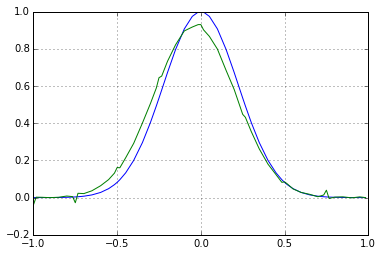

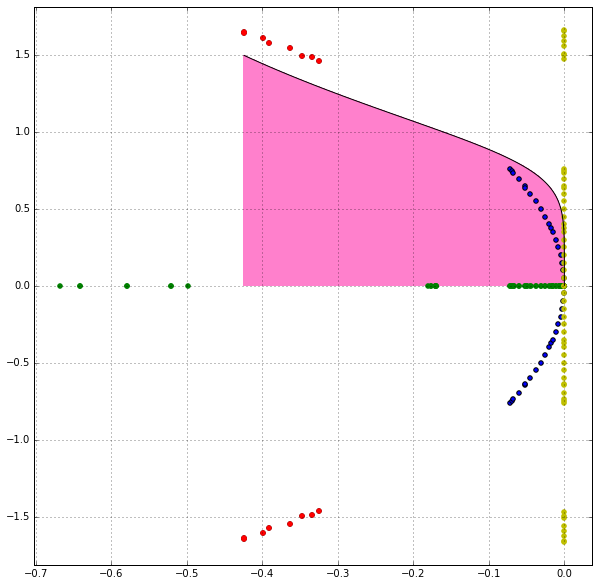

In [11]:
Re = 1024
visc = 2. / Re
plot_stability(Re, 1./64, 4, 1, bdf4)